# This project is conducted by Shivani Thadithal and this project deep dives into the Comprehensive Analysis of Ridge Regression


## Import Essential Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from numpy.linalg import solve
from sklearn.model_selection import train_test_split
import random
from sklearn.base import BaseEstimator

### Custom Built model for Kernel Ridge Regression

In [ ]:
class KernelRidgeRegressor():

    def __init__(self, kernel='linear', l=1, d=1, r=1):
        self.kernel = kernel
        self.l = l
        self.d = d
        self.r = r

    def kernel_linear(self, x1, x2):
        return x1 @ x2

    def kernel_polynomial(self,x1,x2):
        return (self.r + x1 @ x2)**self.d

    def computeK(self, X1, X2):
        kernels = {
            'linear': self.kernel_linear,
            'polynomial': self.kernel_polynomial
        }
        kernel = kernels[self.kernel]
        n1 = X1.shape[0]
        n2 = X2.shape[0]

        K = np.array([[kernel(X1[i],X2[j]) for j in range(n2)] for i in range(n1)])
        return K

    def fit(self, X_train, Y):
        self.X_train = X_train
        K = self.computeK(X_train, X_train)
        lPlusK = self.l * np.eye(K.shape[0]) + K
        self.partial_calculation = np.linalg.inv(lPlusK).dot(Y)

        return self

    def predict(self, X_test):
        k = self.computeK(self.X_train, X_test)
        return self.partial_calculation @ k

    def score(self, X_test, Y):
        predictions = self.predict(X_test)
        return mean_squared_error(Y, predictions)



## Custom dataset generation and Implementation

In [ ]:
# Test the KernelRidgeRegressor class
random.seed(123)
df = pd.DataFrame()
rows = 4
df["x"] = [x for x in range(rows)]
df["y"] = df["x"]*3.32
X_train,X_test,y_train,y_test = train_test_split(df[["x"]].to_numpy(),df["y"].to_numpy(),random_state=42,train_size=0.8)


In [ ]:
# Initialize a list to store the results
results = []

# Test the KernelRidgeRegressor class with different hyperparameters
for l in [1, 0.5]:
    for kernel in ['linear', 'polynomial']:
        for d in [1, 2] if kernel == 'polynomial' else ['NA']:
            for r in [1, 2] if kernel == 'polynomial' else ['NA']:
                regressor = KernelRidgeRegressor(l=l, kernel=kernel, d=d if d != 'NA' else 1, r=r if r != 'NA' else 1)
                regressor.fit(X_train, y_train)
                predictions = regressor.predict(X_test)
                mse = mean_squared_error(y_test, predictions)
                results.append([l, kernel, d, r, mse])

# Convert the results to a pandas DataFrame and display it
results_df = pd.DataFrame(results, columns=['l', 'kernel', 'd', 'r', 'MSE'])
print(results_df)

     l      kernel   d   r       MSE
0  1.0      linear  NA  NA  0.056237
1  1.0  polynomial   1   1  0.011470
2  1.0  polynomial   1   2  0.043056
3  1.0  polynomial   2   1  0.794088
4  1.0  polynomial   2   2  0.300062
5  0.5      linear  NA  NA  0.015120
6  0.5  polynomial   1   1  0.012524
7  0.5  polynomial   1   2  0.023687
8  0.5  polynomial   2   1  0.404695
9  0.5  polynomial   2   2  0.139818


## Implementation on Boston Dataset

In [ ]:
# First, import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.kernel_ridge import KernelRidge

# Read the housing dataset
df = pd.read_csv("housing.csv", delimiter=r"\s+", names=["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT", "MEDV"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="MEDV").to_numpy(), df["MEDV"].to_numpy(), random_state=123, train_size=0.8)


# Define grid of hyperparameters to search over
scalers_dict = {"MinMax": MinMaxScaler(), "Standard": StandardScaler(), "Robust": RobustScaler(), "Normalizer": Normalizer()}
scalers = scalers_dict.keys()
kernels = ["linear", "polynomial"]
ls = [(2**i) for i in range(-8,1)]
ds = [x for x in range(1,5)]
rs = [x for x in np.linspace(0,1000,21)]

# Define dataframe to store results
results = pd.DataFrame(columns=["Scaler", "Kernel", "L", "d", "r", "MSE", "MSE_sklearn"])

# Iterate over hyperparameters
for l in ls:
    for kernel in kernels:
        for d in ds:
            for r in rs:
                for scaler in scalers:
                    # Define and fit the model
                    estimator = KernelRidgeRegressor(kernel=kernel, l=l, d=d, r=r)
                    pipe = make_pipeline(scalers_dict[scaler], estimator)
                    mse = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1).mean()

                    # Compare with sklearn's KernelRidge
                    if kernel == "linear":
                        krr = KernelRidge(alpha=l, kernel='linear')
                    else:
                        krr = make_pipeline(PolynomialFeatures(degree=d), KernelRidge(alpha=l))
                    mse_sklearn = -cross_val_score(krr, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1).mean()


                    # Store results
                    new_row = pd.DataFrame({
                        "Scaler": [scaler],
                        "Kernel": [kernel],
                        "L": [l],
                        "d": [d if kernel == "polynomial" else "NA"],
                        "r": [r if kernel == "polynomial" else "NA"],
                        "MSE": [mse],
                        "MSE_sklearn": [mse_sklearn],
                    })
                    results = pd.concat([results, new_row], ignore_index=True)

# Display results
print(results)

          Scaler      Kernel         L   d       r            MSE  \
0         MinMax      linear  0.003906  NA      NA      27.733294   
1       Standard      linear  0.003906  NA      NA     524.319002   
2         Robust      linear  0.003906  NA      NA     228.307540   
3     Normalizer      linear  0.003906  NA      NA      35.136052   
4         MinMax      linear  0.003906  NA      NA      27.733294   
...          ...         ...       ...  ..     ...            ...   
6043  Normalizer  polynomial  1.000000   4   950.0      19.577903   
6044      MinMax  polynomial  1.000000   4  1000.0      31.184335   
6045    Standard  polynomial  1.000000   4  1000.0    2574.766713   
6046      Robust  polynomial  1.000000   4  1000.0  803167.589564   
6047  Normalizer  polynomial  1.000000   4  1000.0      19.582733   

       MSE_sklearn  
0        24.106864  
1        24.106864  
2        24.106864  
3        24.106864  
4        24.106864  
...            ...  
6043  10711.616938  
604

In [ ]:
# Sort the results dataframe based on MSE for custom made kernel ridge regression and print top 5
results_sorted_custom = results.sort_values(by='MSE', ascending=True)
print("Top 5 parameters for custom Kernel Ridge Regression:")
print(results_sorted_custom.head(5))

Top 5 parameters for custom Kernel Ridge Regression:
      Scaler      Kernel      L  d      r       MSE  MSE_sklearn
3784  MinMax  polynomial  0.125  2   50.0  9.605145    15.392366
3788  MinMax  polynomial  0.125  2  100.0  9.606258    15.392366
3792  MinMax  polynomial  0.125  2  150.0  9.606690    15.392366
3796  MinMax  polynomial  0.125  2  200.0  9.606917    15.392366
3800  MinMax  polynomial  0.125  2  250.0  9.607057    15.392366


# Best Parameters


Scaler : **MinMax**

Kernel :**polynomial**  

L: **0.125**  

r: **2**  

d: **50.0**  

Lowest MSE: **9.605145**

In [ ]:
# Sort the results dataframe based on MSE for sklearn's kernel ridge and print top 5
results_sorted_sklearn = results.sort_values(by='MSE_sklearn', ascending=True)
print("\nTop 5 parameters for sklearn's Kernel Ridge Regression:")
print(results_sorted_sklearn.head(5))

In [ ]:
results.to_csv('result.csv')

## Analysis of Results

In [ ]:
data = pd.read_csv('result.csv')

In [ ]:
data.head()

,Unnamed: 0,Scaler,Kernel,L,d,r,MSE,MSE_sklearn
0,0,MinMax,linear,0.003906,NaN,NaN,27.733294,24.106864
1,1,Standard,linear,0.003906,NaN,NaN,524.319002,24.106864
2,2,Robust,linear,0.003906,NaN,NaN,228.307540,24.106864
3,3,Normalizer,linear,0.003906,NaN,NaN,35.136052,24.106864
4,4,MinMax,linear,0.003906,NaN,NaN,27.733294,24.106864


In [ ]:
# Checking the shape of the data
data.shape

(6048, 8)

In [ ]:
# Checking unique values in the Scaler, Kernel, and L columns
scalers = data['Scaler'].unique()
kernels = data['Kernel'].unique()
L_values = data['L'].nunique()

# Checking basic statistics of MSE and MSE_sklearn columns
mse_stats = data['MSE'].describe()
mse_sklearn_stats = data['MSE_sklearn'].describe()

scalers, kernels, L_values, mse_stats, mse_sklearn_stats

(array(['MinMax', 'Standard', 'Robust', 'Normalizer'], dtype=object),
 array(['linear', 'polynomial'], dtype=object),
 9,
 count    6.048000e+03
 mean     1.226434e+06
 std      4.314157e+07
 min      9.605145e+00
 25%      2.257132e+01
 50%      4.492145e+01
 75%      2.283064e+02
 max      2.692584e+09
 Name: MSE, dtype: float64,
 count     6048.000000
 mean      1395.260362
 std       3522.869755
 min         14.565406
 25%         23.845933
 50%         24.103644
 75%         83.608171
 max      10711.616938
 Name: MSE_sklearn, dtype: float64)

In [ ]:
# Checking the combinations of Scaler, Kernel, and L that lead to the lowest MSEs for the custom implementation
lowest_mse_combinations = data.sort_values('MSE').head(10)[['Scaler', 'Kernel', 'L', 'MSE']]

# Checking the combinations of Scaler, Kernel, and L that lead to the lowest MSEs for the sklearn implementation
lowest_mse_sklearn_combinations = data.sort_values('MSE_sklearn').head(10)[['Scaler', 'Kernel', 'L', 'MSE_sklearn']]

lowest_mse_combinations

,Scaler,Kernel,L,MSE
3784,MinMax,polynomial,0.125,9.605145
3788,MinMax,polynomial,0.125,9.606258
3792,MinMax,polynomial,0.125,9.606690
3796,MinMax,polynomial,0.125,9.606917
3800,MinMax,polynomial,0.125,9.607057
3804,MinMax,polynomial,0.125,9.607152
3808,MinMax,polynomial,0.125,9.607221
3812,MinMax,polynomial,0.125,9.607273
3816,MinMax,polynomial,0.125,9.607314
3820,MinMax,polynomial,0.125,9.607346


In [ ]:
lowest_mse_sklearn_combinations

,Scaler,Kernel,L,MSE_sklearn
5797,Standard,polynomial,1.0,14.565406
5820,MinMax,polynomial,1.0,14.565406
5821,Standard,polynomial,1.0,14.565406
5822,Robust,polynomial,1.0,14.565406
5823,Normalizer,polynomial,1.0,14.565406
5824,MinMax,polynomial,1.0,14.565406
5825,Standard,polynomial,1.0,14.565406
5826,Robust,polynomial,1.0,14.565406
5827,Normalizer,polynomial,1.0,14.565406
5828,MinMax,polynomial,1.0,14.565406


Plotting the distribution of MSE for each Scaler again


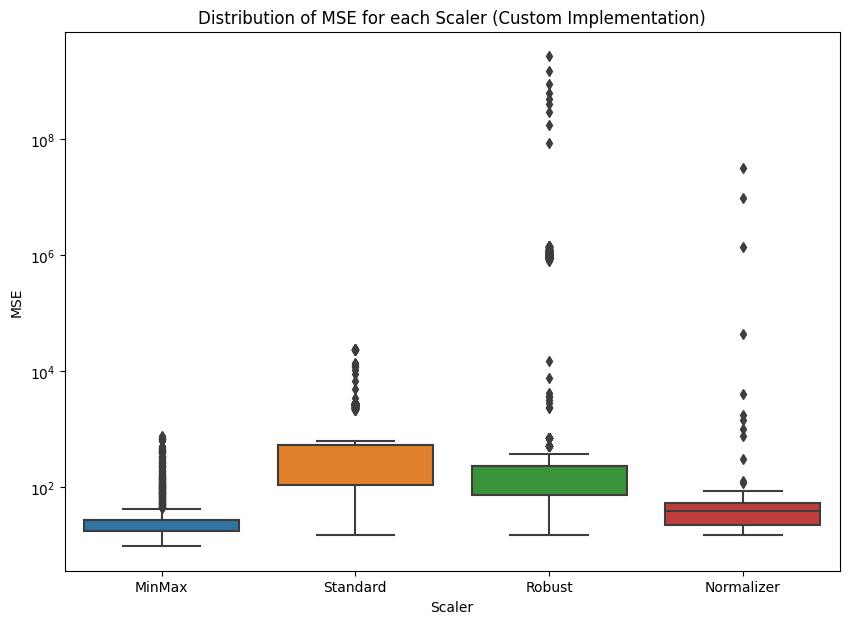

In [ ]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Scaler', y='MSE', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each Scaler (Custom Implementation)')
plt.show()

### Plotting the distribution of MSE_sklearn for each Scaler


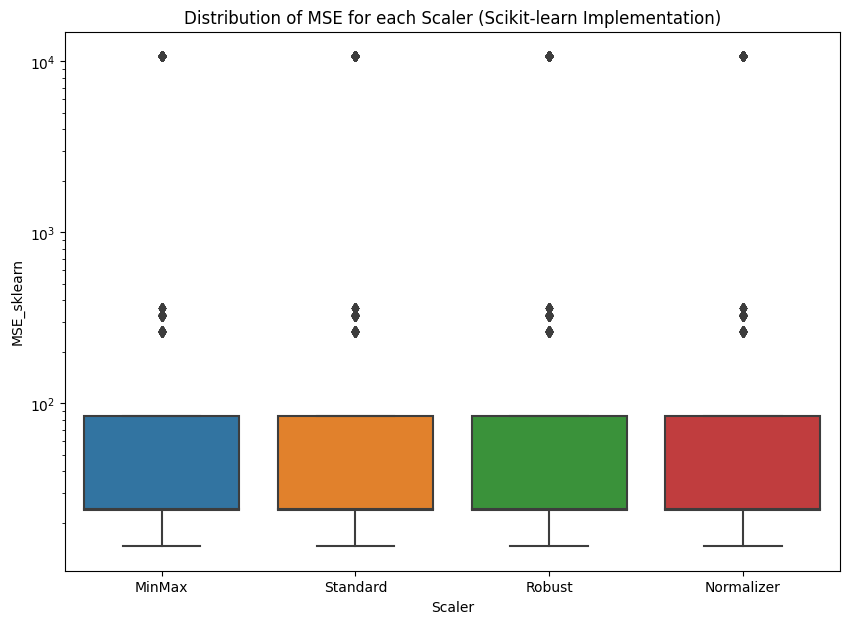

In [ ]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Scaler', y='MSE_sklearn', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each Scaler (Scikit-learn Implementation)')
plt.show()


### Plotting the distribution of MSE for each Kernel


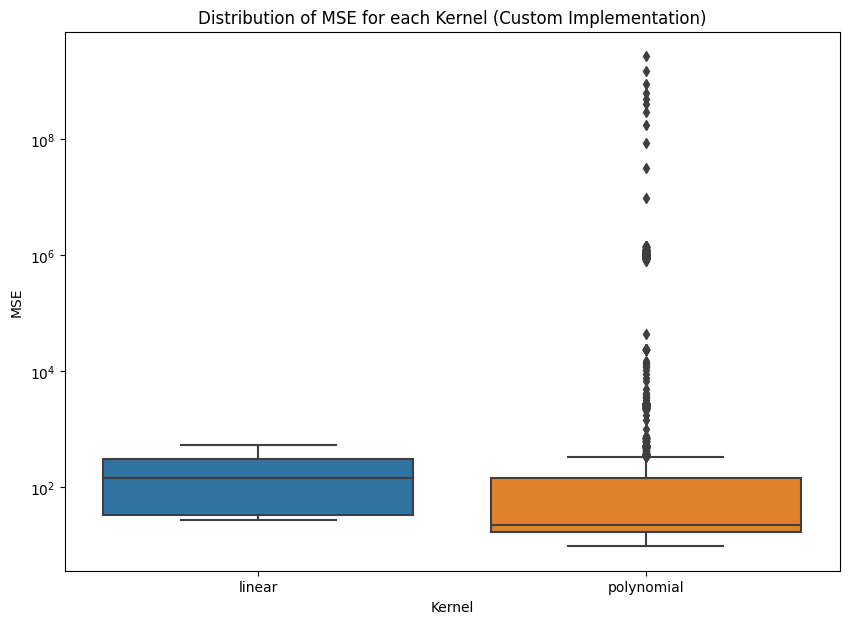

In [ ]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Kernel', y='MSE', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each Kernel (Custom Implementation)')
plt.show()

### Plotting the distribution of MSE_sklearn for each Kernel


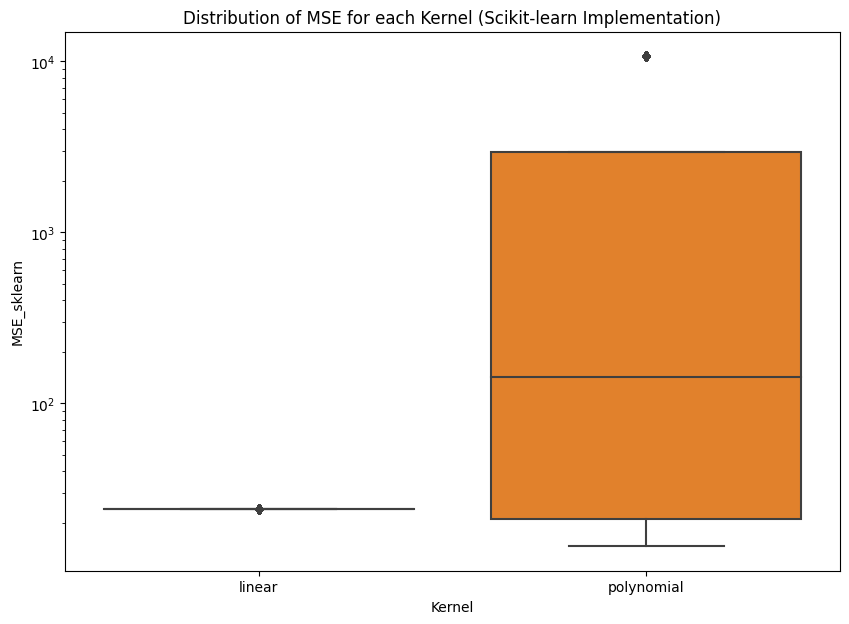

In [ ]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Kernel', y='MSE_sklearn', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each Kernel (Scikit-learn Implementation)')
plt.show()


### Plotting the trend of MSE with varying L values


<ipython-input-17-e7c10d7cd096>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='L', y='MSE', data=data, ci=None)


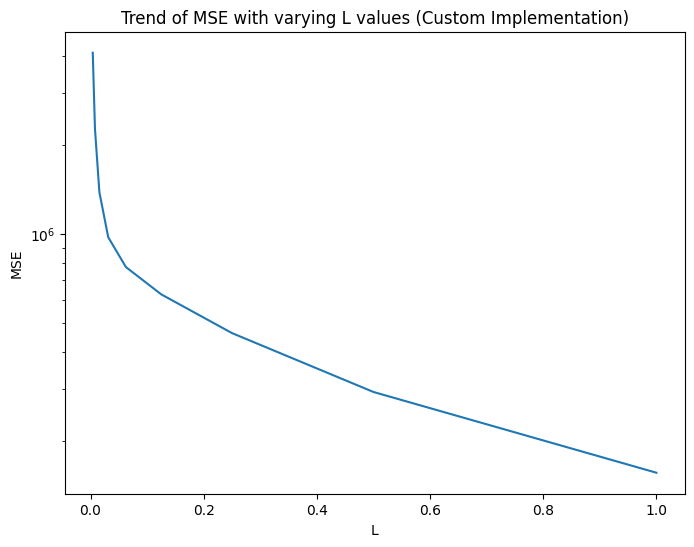

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='L', y='MSE', data=data, ci=None)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Trend of MSE with varying L values (Custom Implementation)')
plt.show()

### Plotting the trend of MSE_sklearn with varying L values


<ipython-input-22-c502d6ca1392>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='L', y='MSE_sklearn', data=data, ci=None)


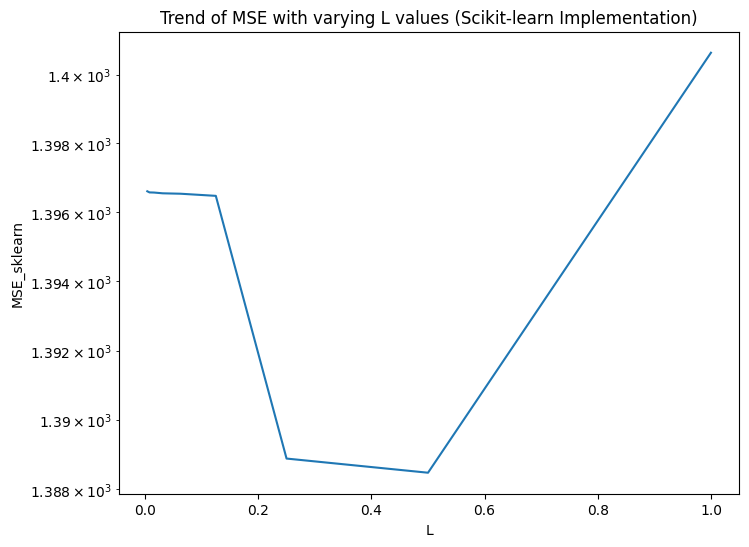

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='L', y='MSE_sklearn', data=data, ci=None)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Trend of MSE with varying L values (Scikit-learn Implementation)')
plt.show()


### Plotting the distribution of MSE for each implementation


<ipython-input-19-5390c8cff228>:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  data_melted = data.melt(id_vars=['Scaler', 'Kernel', 'L'],


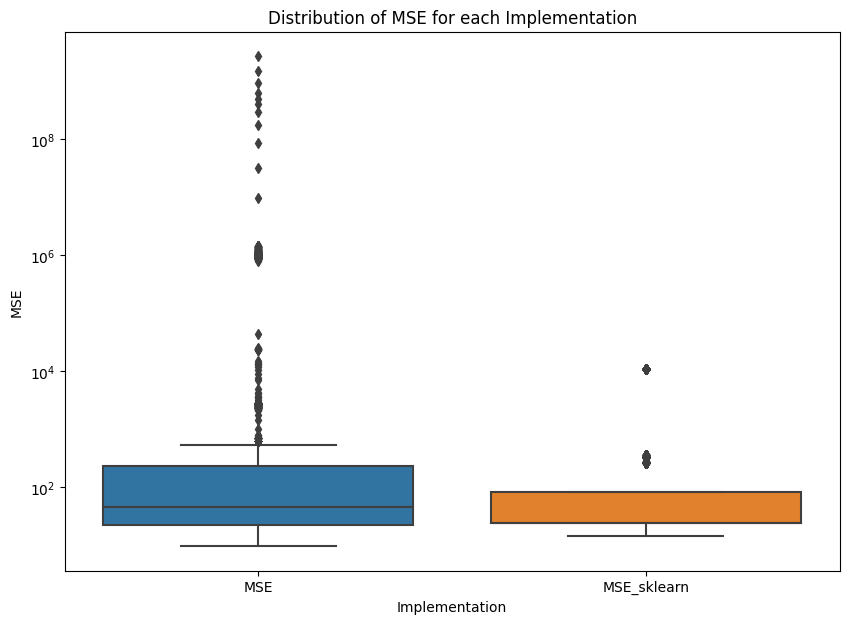

In [ ]:
# Adding a column to indicate the source of MSE (custom implementation or sklearn)
data_melted = data.melt(id_vars=['Scaler', 'Kernel', 'L'],
                        value_vars=['MSE', 'MSE_sklearn'],
                        var_name='Implementation',
                        value_name='MSE')

# Plotting the distribution of MSE for each implementation
plt.figure(figsize=(10, 7))
sns.boxplot(x='Implementation', y='MSE', data=data_melted)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each Implementation')
plt.show()

### Plotting the distribution of MSE for each Scaler and Kernel combination (Custom Implementation)


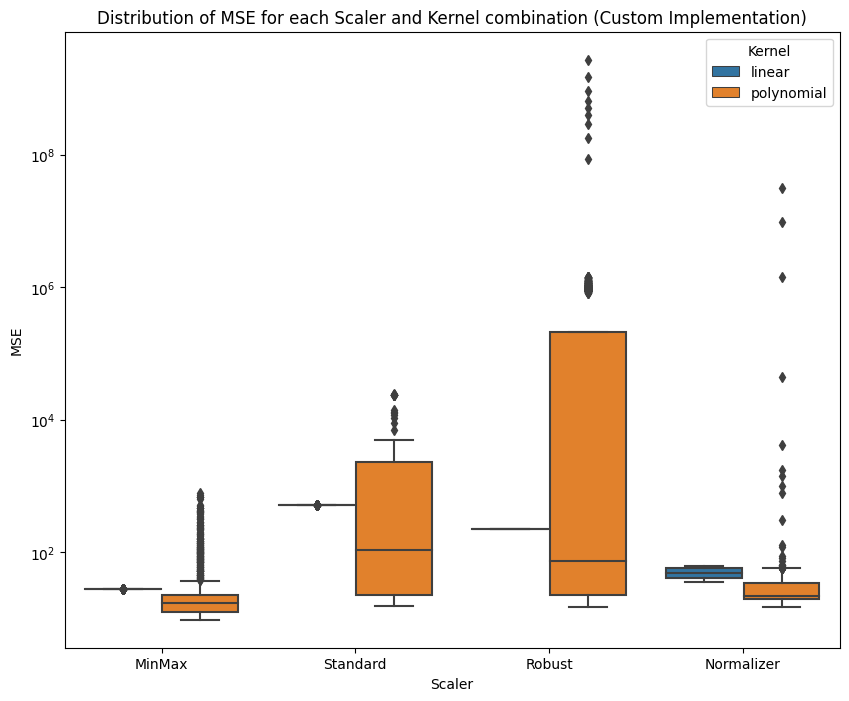

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Scaler', y='MSE', hue='Kernel', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each Scaler and Kernel combination (Custom Implementation)')
plt.show()

### Plotting the distribution of MSE_sklearn for each Scaler and Kernel combination


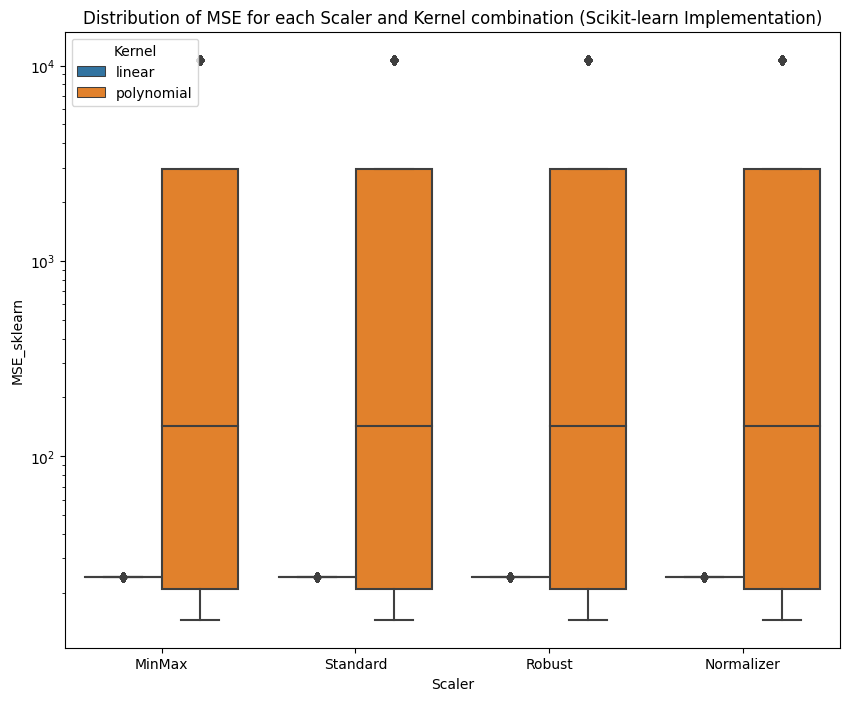

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Scaler', y='MSE_sklearn', hue='Kernel', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each Scaler and Kernel combination (Scikit-learn Implementation)')
plt.show()

### Plotting the trend of MSE with varying L values for each Scaler (Custom Implementation)


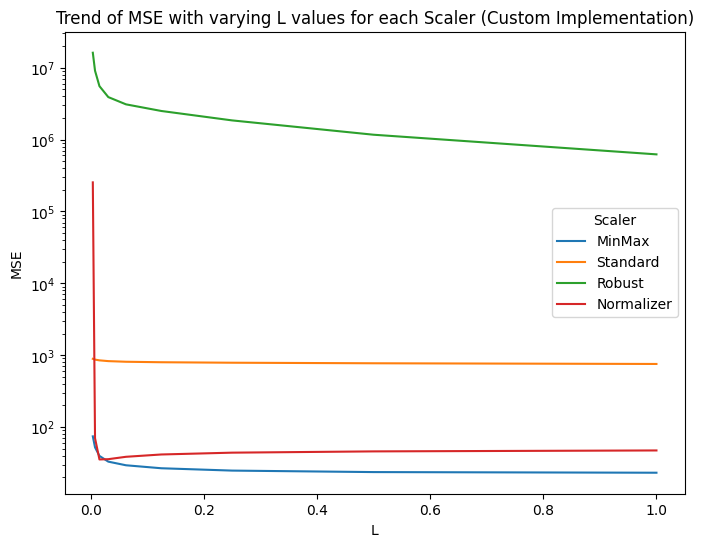

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='L', y='MSE', hue='Scaler', data=data, errorbar=None)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Trend of MSE with varying L values for each Scaler (Custom Implementation)')
plt.show()

### Plotting the trend of MSE with varying L values for each Kernel (Custom Implementation)


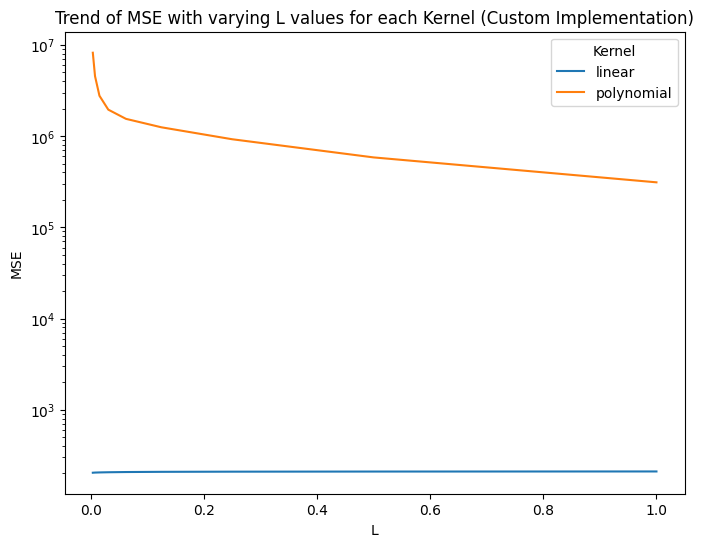

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='L', y='MSE', hue='Kernel', data=data, errorbar=None)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Trend of MSE with varying L values for each Kernel (Custom Implementation)')
plt.show()

### Plotting the trend of MSE_sklearn with varying L values for each Kernel


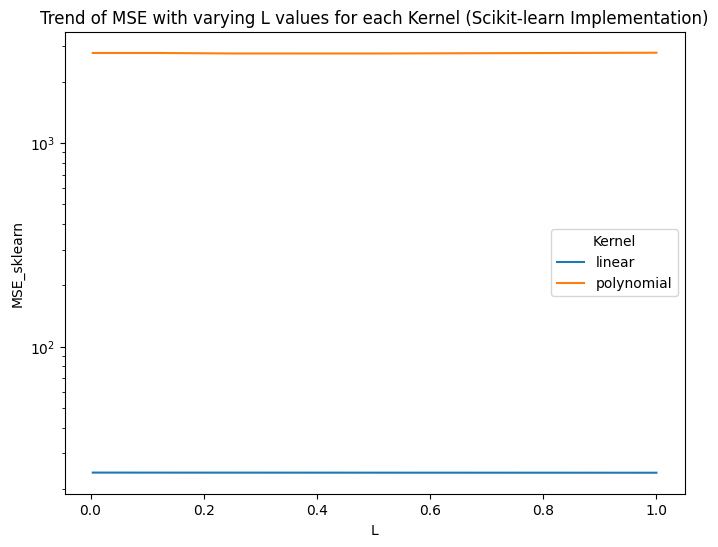

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='L', y='MSE_sklearn', hue='Kernel', data=data, errorbar=None)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Trend of MSE with varying L values for each Kernel (Scikit-learn Implementation)')
plt.show()


### Plotting the distribution of MSE for these top combinations


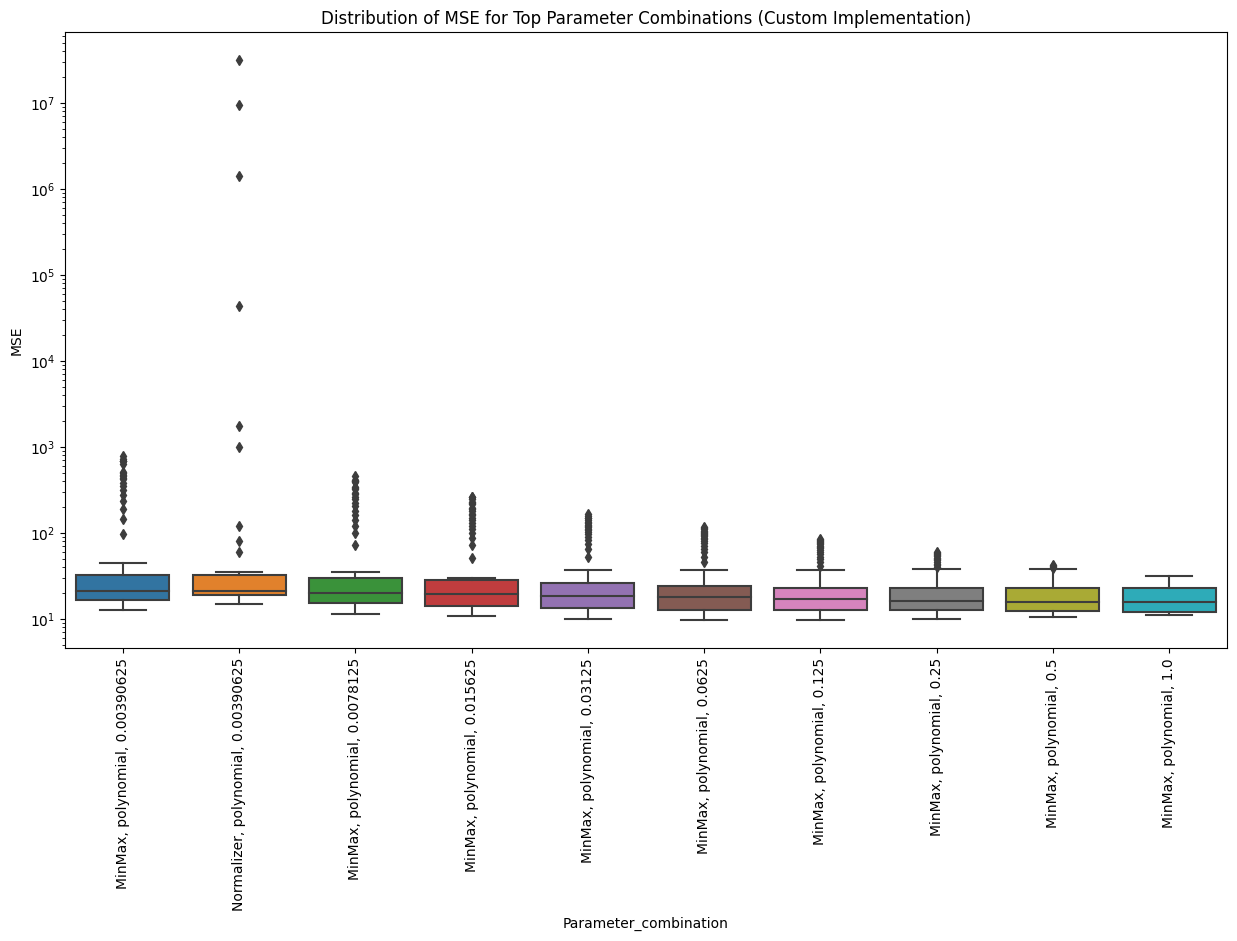

In [ ]:
# Create a new column that combines the Scaler, Kernel, and L values
data['Parameter_combination'] = data['Scaler'] + ', ' + data['Kernel'] + ', ' + data['L'].astype(str)

# Get the top 10 parameter combinations with the lowest median MSE (custom implementation)
top_combinations = data.groupby('Parameter_combination')['MSE'].median().nsmallest(10).index

# Filter the data for these top combinations
top_combinations_data = data[data['Parameter_combination'].isin(top_combinations)]

# Plot the distribution of MSE for these top combinations
plt.figure(figsize=(15, 8))
sns.boxplot(x='Parameter_combination', y='MSE', data=top_combinations_data)
plt.xticks(rotation=90)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for Top Parameter Combinations (Custom Implementation)')
plt.show()

### Plotting the distribution of MSE for each r value (Custom Implementation)


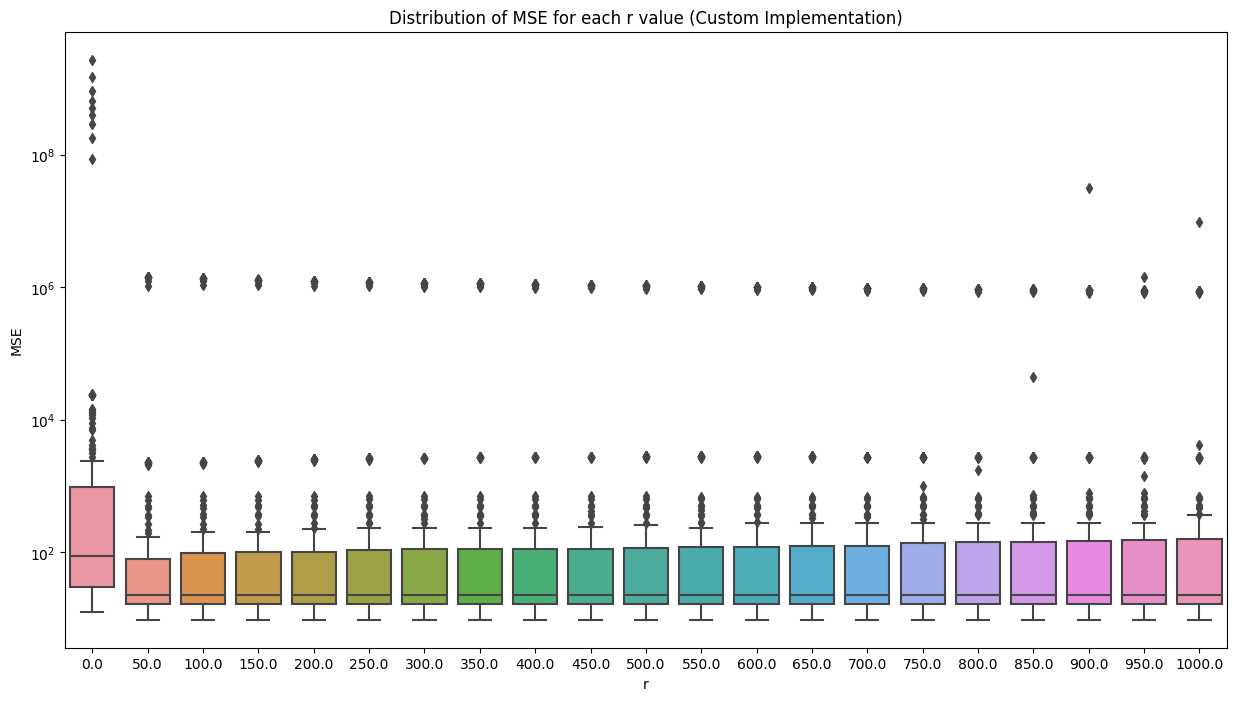

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='r', y='MSE', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each r value (Custom Implementation)')
plt.show()

Plotting the distribution of MSE for each d value (Custom Implementation)


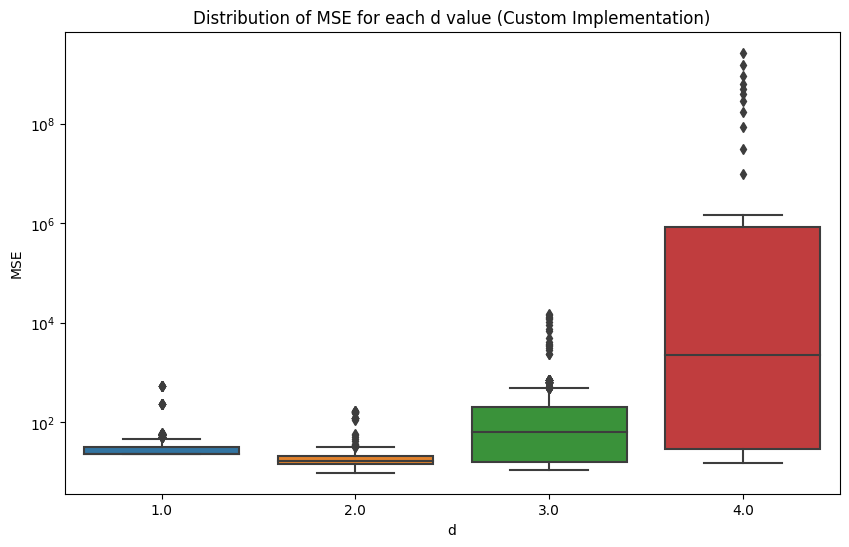

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='d', y='MSE', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each d value (Custom Implementation)')
plt.show()

Plotting the trend of MSE with varying r values for each d value (Custom Implementation)


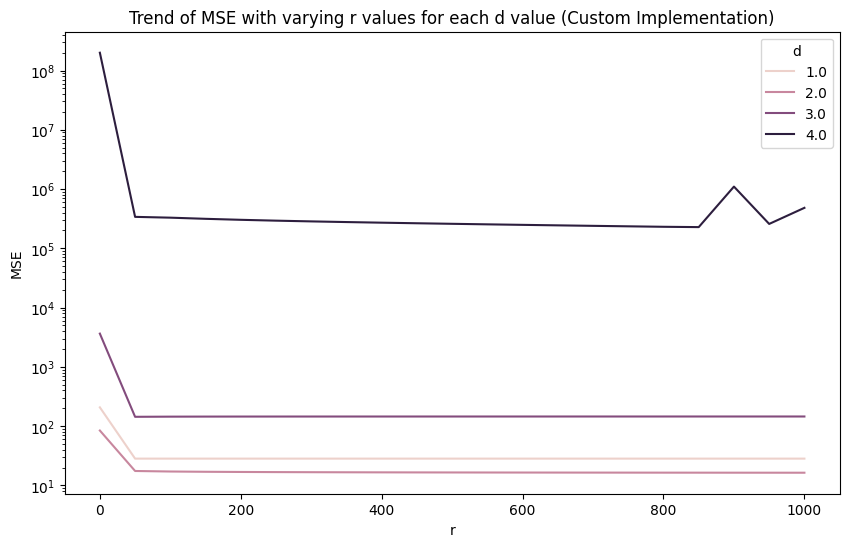

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='r', y='MSE', hue='d', data=data, errorbar=None)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Trend of MSE with varying r values for each d value (Custom Implementation)')
plt.show()


### 1. Plotting the distribution of MSE_sklearn for each r value

### 2. Plotting the distribution of MSE_sklearn for each d value



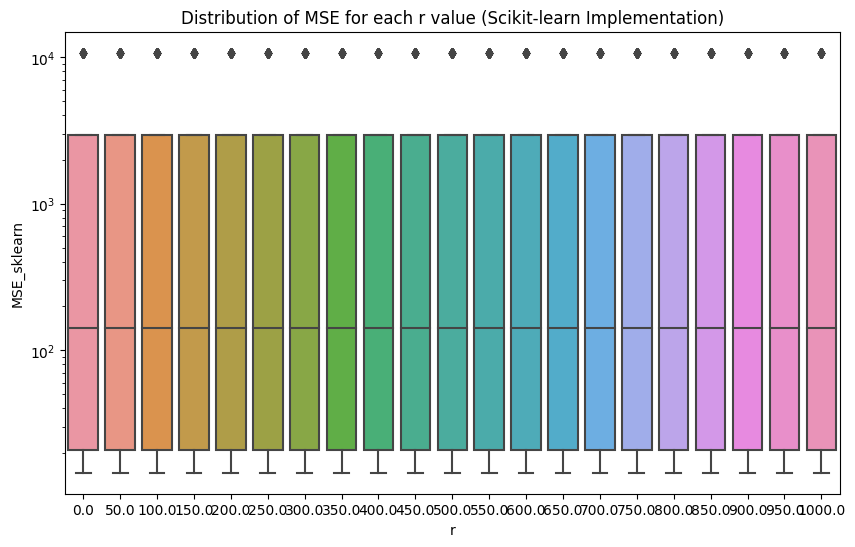

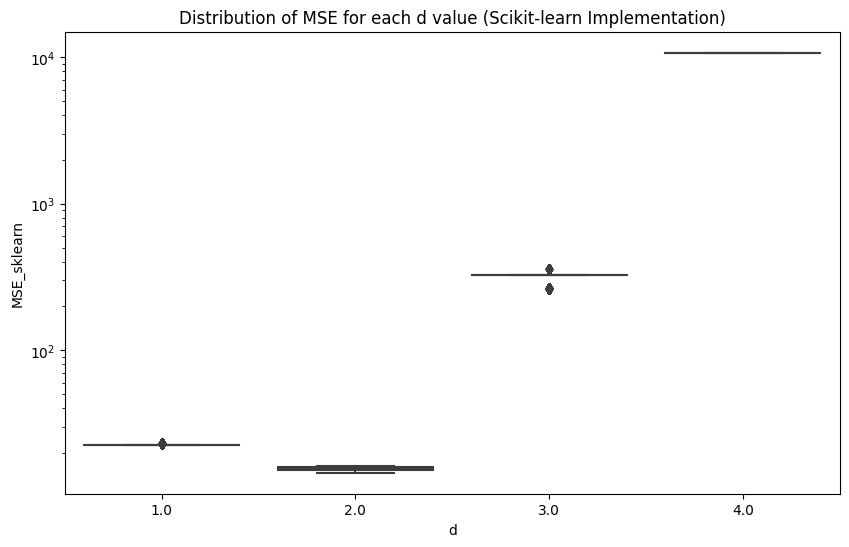

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='r', y='MSE_sklearn', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each r value (Scikit-learn Implementation)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='d', y='MSE_sklearn', data=data)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Distribution of MSE for each d value (Scikit-learn Implementation)')
plt.show()


### Plotting the trend of MSE_sklearn with varying r values for each d value


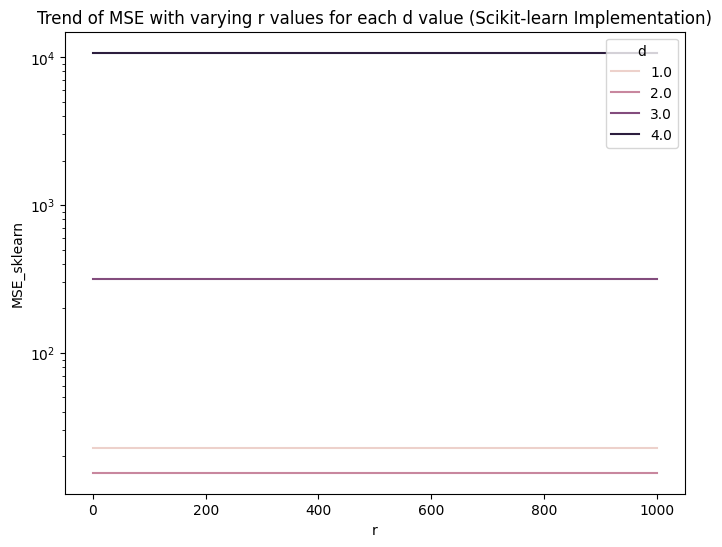

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='r', y='MSE_sklearn', hue='d', data=data, errorbar=None)
plt.yscale('log')  # Using log scale for better visualization due to high outliers
plt.title('Trend of MSE with varying r values for each d value (Scikit-learn Implementation)')
plt.show()